## Импорты

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.5 MB/s eta 0:00:00


Распаковка датасета и разделение на train, val и test части

In [ ]:
IMAGE_PATH = '/content/CamVid/images/'
MASK_PATH = '/content/CamVid/masks/'

In [ ]:
n_classes = 13

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  701


In [ ]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  535
Val Size     :  95
Test Size    :  71


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=480x360 at 0x7E9FFCAFD780>
Image Size (360, 480, 3)
Mask Size (360, 480)


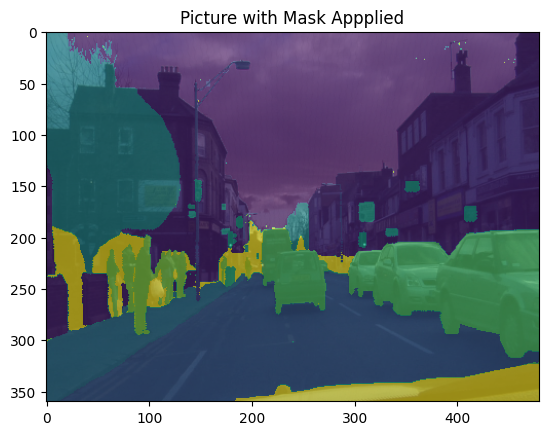

In [ ]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.png')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(np.asarray(img))
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

## Класс для тренировочного датасета

In [ ]:
class MyDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        return img, mask

## Datasets & Dataloaders

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(384, 480, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(384, 480, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = MyDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train)
val_set = MyDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val)

#dataloader
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

## Метрики

Точность ($pixel Accuracy$) совпадения пикселей маски с выходным результатом сети

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=13):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

## Функция обучения

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                print('saving model...')
                # Сохранение модели с возможностью дальнейшего дообучения
                torch.save({
                    'epoch': e,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'loss_function_state_dict': criterion
                    }, 'model_for_train.pt')
                torch.save(model, 'torch_best.model.pt')


            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

## Инициализация модели

In [ ]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=13, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

## Обучение

In [ ]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.993 
saving model...
Epoch:1/15.. Train Loss: 1.761.. Val Loss: 0.993.. Train mIoU:0.209.. Val mIoU: 0.345.. Train Acc:0.550.. Val Acc:0.816.. Time: 0.62m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.993 >> 0.582 
saving model...
Epoch:2/15.. Train Loss: 0.851.. Val Loss: 0.582.. Train mIoU:0.326.. Val mIoU: 0.384.. Train Acc:0.788.. Val Acc:0.840.. Time: 0.58m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 0.684.. Val Loss: 0.618.. Train mIoU:0.353.. Val mIoU: 0.378.. Train Acc:0.802.. Val Acc:0.821.. Time: 0.58m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 0.642.. Val Loss: 0.615.. Train mIoU:0.367.. Val mIoU: 0.357.. Train Acc:0.808.. Val Acc:0.824.. Time: 0.58m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.582 >> 0.479 
saving model...
Epoch:5/15.. Train Loss: 0.565.. Val Loss: 0.479.. Train mIoU:0.392.. Val mIoU: 0.424.. Train Acc:0.827.. Val Acc:0.849.. Time: 0.58m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.479 >> 0.442 
saving model...
Epoch:6/15.. Train Loss: 0.526.. Val Loss: 0.442.. Train mIoU:0.425.. Val mIoU: 0.474.. Train Acc:0.839.. Val Acc:0.866.. Time: 0.58m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.442 >> 0.388 
saving model...
Epoch:7/15.. Train Loss: 0.449.. Val Loss: 0.388.. Train mIoU:0.471.. Val mIoU: 0.505.. Train Acc:0.861.. Val Acc:0.885.. Time: 0.58m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.388 >> 0.354 
saving model...
Epoch:8/15.. Train Loss: 0.457.. Val Loss: 0.354.. Train mIoU:0.476.. Val mIoU: 0.515.. Train Acc:0.860.. Val Acc:0.890.. Time: 0.59m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.354 >> 0.344 
saving model...
Epoch:9/15.. Train Loss: 0.461.. Val Loss: 0.344.. Train mIoU:0.479.. Val mIoU: 0.531.. Train Acc:0.859.. Val Acc:0.892.. Time: 0.58m


  0%|          | 0/179 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Загрузка модели для дообучения

In [ ]:
checkpoint = torch.load('model_for_train.pt')

loss = checkpoint['loss_function_state_dict']
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
sch_dict = checkpoint['scheduler_state_dict']
sch_dict['total_steps'] = sch_dict['total_steps'] + epoch * int(len(train_loader))
sched.load_state_dict(sch_dict)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']


## Процесс дообучения

In [ ]:
history = fit(epoch, model, train_loader, val_loader, loss, optimizer, sched)

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.820 
saving model...
Epoch:1/3.. Train Loss: 0.585.. Val Loss: 0.820.. Train mIoU:0.385.. Val mIoU: 0.360.. Train Acc:0.827.. Val Acc:0.802.. Time: 0.67m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.820 >> 0.445 
saving model...
Epoch:2/3.. Train Loss: 0.543.. Val Loss: 0.445.. Train mIoU:0.402.. Val mIoU: 0.437.. Train Acc:0.835.. Val Acc:0.867.. Time: 0.61m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.445 >> 0.392 
saving model...
Epoch:3/3.. Train Loss: 0.498.. Val Loss: 0.392.. Train mIoU:0.428.. Val mIoU: 0.488.. Train Acc:0.848.. Val Acc:0.879.. Time: 0.63m
Total time: 1.91 m


## Функции для вывода графиков обучения

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

Графики выведены для процесса дообучения модели (3 эпохи)

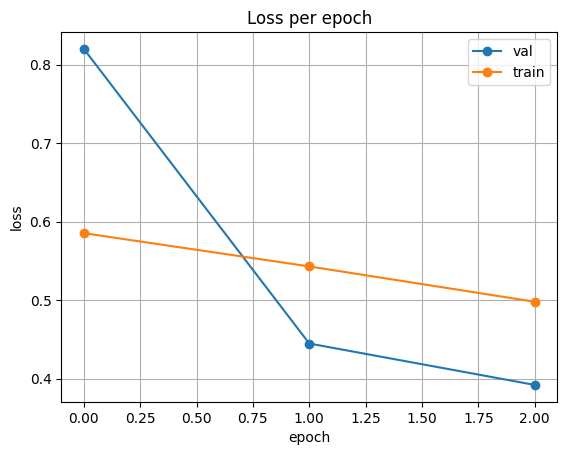

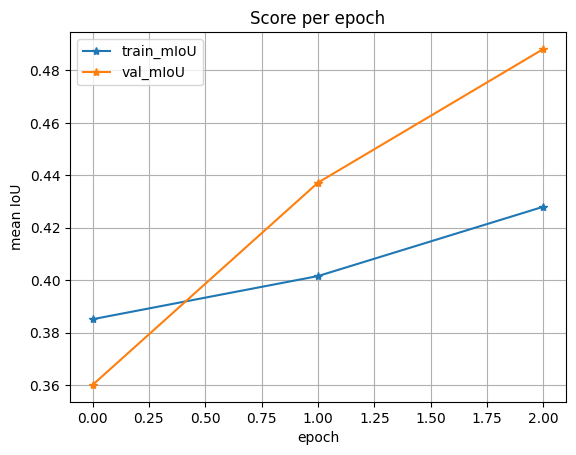

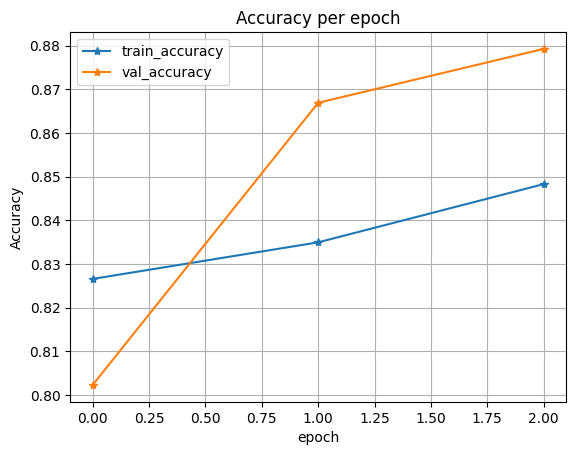

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

## Predict, score & accuracy

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

## Класс для тестового набора данных

In [ ]:
class TestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(384, 480, interpolation=cv2.INTER_NEAREST)
test_set = TestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

mob_acc = pixel_acc(model, test_set)
print('Test Set Pixel Accuracy', np.mean(mob_acc))

  0%|          | 0/71 [00:00<?, ?it/s]

Test Set Pixel Accuracy 0.8899573002249609


In [ ]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/71 [00:00<?, ?it/s]

In [ ]:
image, mask = test_set[2]
pred_mask, score = predict_image_mask_miou(model, image, mask)

## Визуализация предиктов на тестовом датасете

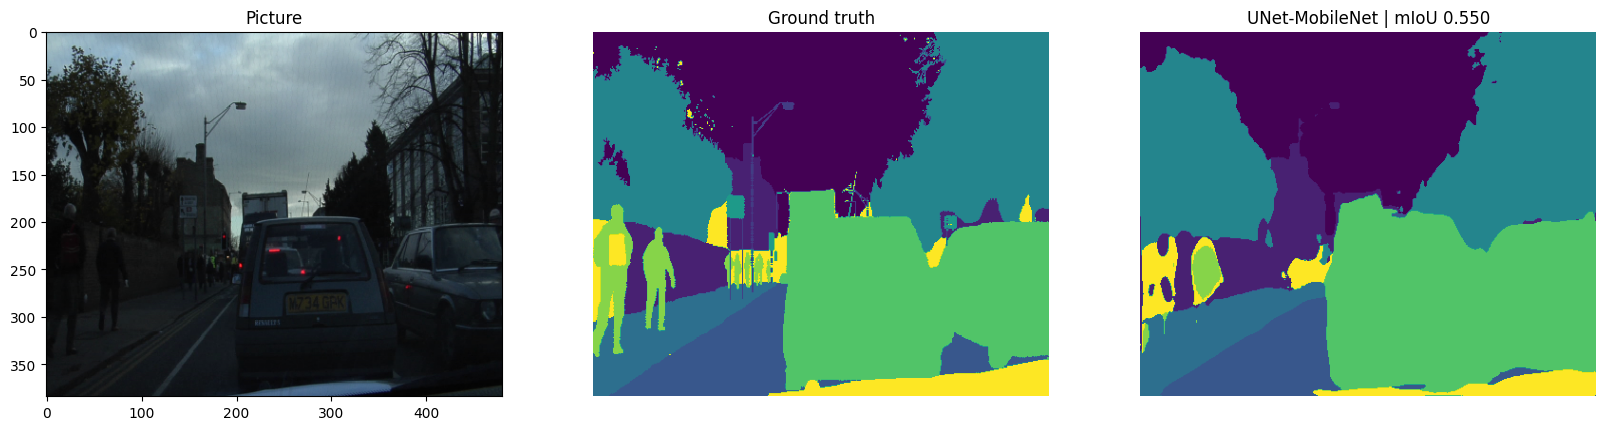

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.5174262387316086


## Функция предикта для одного изображения

In [50]:
def predict_one_image(model, image_path, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = A.Resize(384, 480, interpolation=cv2.INTER_NEAREST)
    aug = transform(image=image)
    image = Image.fromarray(aug['image'])

    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)

        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [19]:
def visualize(image_path, predicted_mask):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(predicted_mask)
  ax2.set_title('Predicted mask')
  ax2.set_axis_off()

In [5]:
PATH = '/content/Unet-Mobilenet_v2_best.pt'
model = torch.load(PATH)

In [ ]:
image_path = '/content/CamVid/images/0001TP_007110.png'

(384, 480, 3)


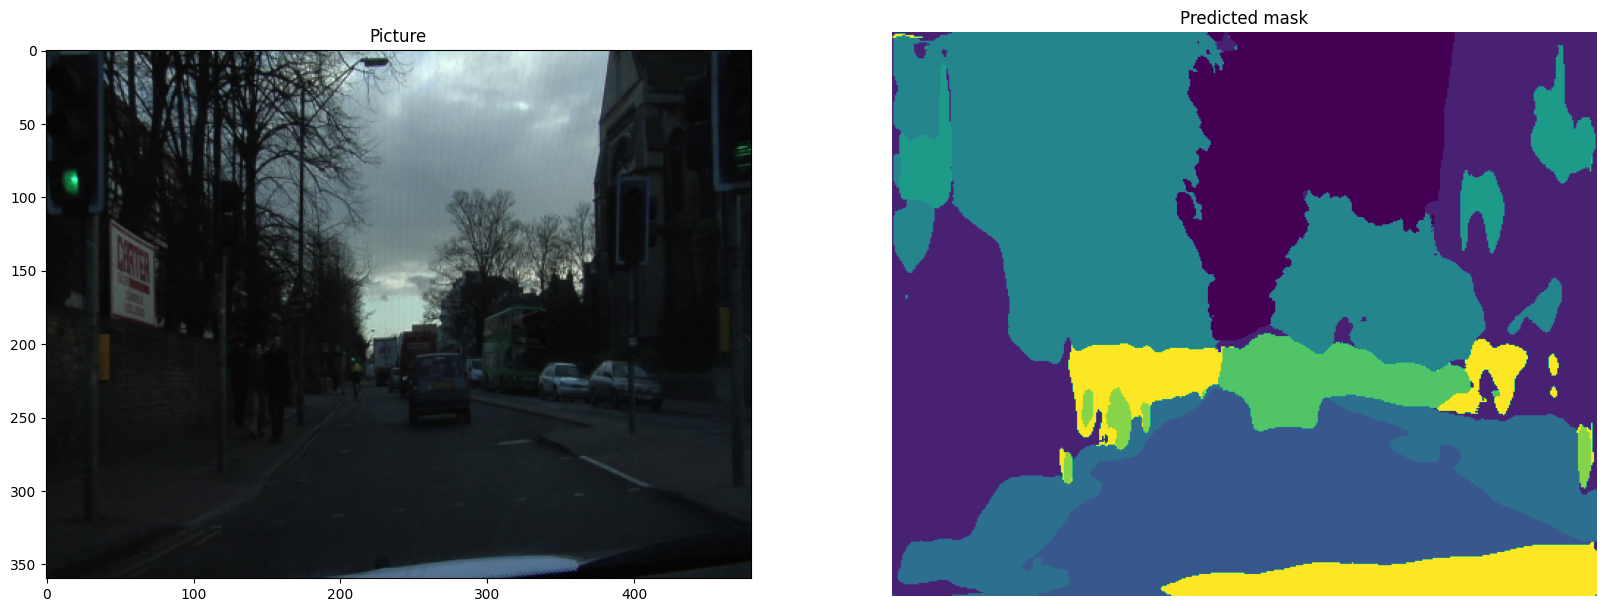

In [ ]:
predicted_mask = predict_one_image(model, image_path)
visualize(image_path, predicted_mask)

In [ ]:
image_array = np.array(predicted_mask)
cv2.imwrite('predicted_mask.png', image_array)

True

# ONNX

## Перевод модели в ONNX

In [2]:
from pathlib import Path
import warnings
import onnxruntime as ort
import onnx

In [47]:
image_path = '/content/0001TP_006690.png'

В качестве dummy беру изображение из датасета

In [32]:
transform = T.Compose([T.Resize((384,480)),
                       T.ToTensor(),
                       T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
image = Image.open(image_path)
input_tensor = transform(image).unsqueeze(0)

Экспорт модели в формат ONNX

In [39]:
onnx_path = 'segmentation_model.onnx'
dynamic_axes = {'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
torch.onnx.export(model, input_tensor.cuda(), onnx_path, input_names=['input'],
                  output_names=['output'], dynamic_axes=dynamic_axes)

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [43]:
session = ort.InferenceSession('segmentation_model.onnx')

## Функция предсказания маски с моделью в формате ONNX

In [44]:
def predict_mask_onnx(image_path):

  transform = T.Compose([T.Resize((384,480)),
                       T.ToTensor(),
                       T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

  image = Image.open(image_path)
  input_tensor = transform(image).unsqueeze(0)

  input_name = session.get_inputs()[0].name
  output_name = session.get_outputs()[0].name

  input_data = {input_name: input_tensor.numpy()}
  output_data = session.run([output_name], input_data)

  segmentation_map = output_data[0]
  seg_map = torch.from_numpy(segmentation_map)
  mask = torch.argmax(seg_map, dim=1)
  mask = mask.cpu().squeeze(0)
  return mask

In [55]:
mask_onnx = predict_mask_onnx(image_path)
mask_pt = predict_one_image(model, image_path)

## Сравнение предсказаний моделей

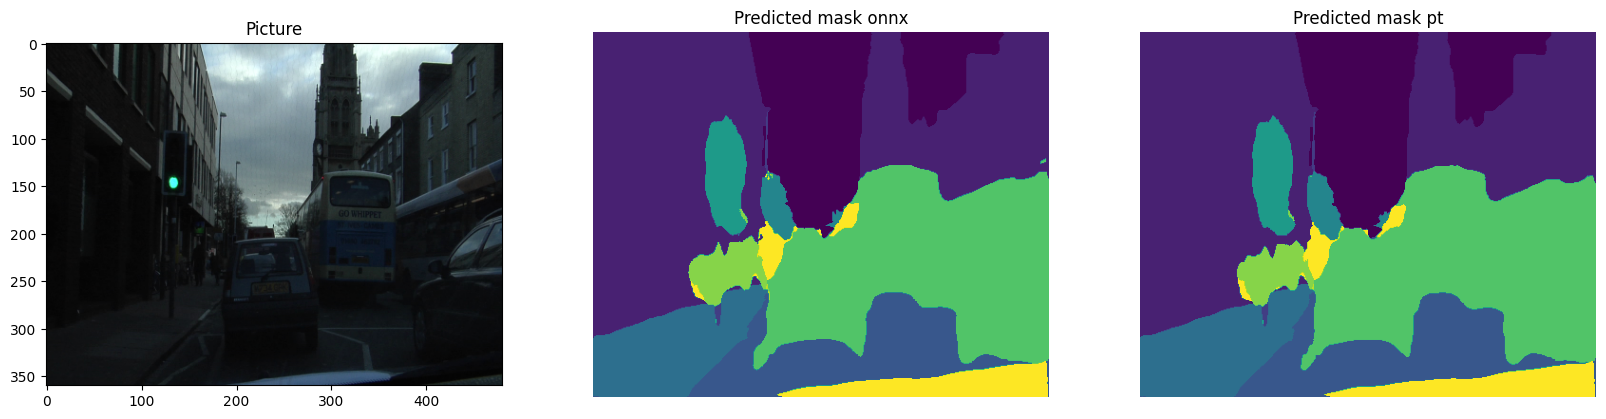

In [56]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask_onnx)
ax2.set_title('Predicted mask onnx')
ax2.set_axis_off()

ax3.imshow(mask_pt)
ax3.set_title('Predicted mask pt')
ax3.set_axis_off()